In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('dstest.csv')
df.head()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235


#### Question 1

Knowing the goal of the our technology, define a metric to measure our performance. Calculate that performance score for each of the companies in the dataset.

For each company , we can define a metric average percentage of volume downloaded by p2p network in timespan 2 min
percentage = total_volume_p2p / total_volume_p2p + total_volume_cdn

In [4]:
metric = []
for com in  df.company.unique():
    total_volume_p2p = df.loc[df.company == com, 'p2p'].sum()
    total_volume_cdn = df.loc[df.company == com, 'cdn'].sum()
    percentage = total_volume_p2p / (total_volume_p2p + total_volume_cdn)
    metric.append([com, percentage])
metric

[['Streamroot TV', 0.5472880588096204],
 ['Flash Infos', 0.39405644031384546],
 ['Sports News', 0.21991367591156838]]

#### Question 2

##### 2.1
How can we know whether a payload is the first payload of a viewer's session?

by asserting if sessionDuration is lesser than a timespan : 2 min

In [5]:
def is_first_payload(row):
    return row['sessionDuration'] <= 2 * 60 * 1000

##### 2.2
Add a column `isFirstPayload` to the dataset, that must be `True` if the row represents a payload that was **the first payload** sent by a viewer, and `False` otherwise.

In [6]:
df['isFirstPayload'] = df.apply(lambda row: is_first_payload(row), axis=1)
df.head()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,isFirstPayload
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235,True
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235,False
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235,False
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235,False
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235,False


##### 2.3
Use that column to calculate the **number of distinct viewers** that sent payloads for each company.

Didn't understand the relation between number of distinct viewers and viewers who send the 1 payload.
For me, each viewer is distinguished by his starting timestamp = current timestamp - duration

In [7]:
distinct_viewers = []
def get_starting_time(row):
    return row['timestamp'] - row['sessionDuration']
df['startingTime'] = df.apply(lambda row: get_starting_time(row), axis=1)
for com in  df.company.unique():
    result = df.loc[df.company == com, 'startingTime'].nunique()
    distinct_viewers.append([com, result])

distinct_viewers

[['Streamroot TV', 338262], ['Flash Infos', 11531], ['Sports News', 1705]]

#### Question 3

##### 3.1
Let's consider a viewer A who starts a video at T=0, then has a playback error at **T = 2 minutes 30 seconds**, and then another one at **T=6 minutes 20 seconds**. What will be the values of the fields `playbackErrorCount` and `totalPlaybackErrorCount` in the first 5 payloads sent by viewer A?

it would be :

In [8]:
payloads = [[0, 0],
            [1, 1],
            [0, 1],
            [1, 2],
            [0, 2]]



##### 3.2
Calculate the **number of distinct viewers** that had **at least 1** playback error during their session.


In [9]:
df.loc[df.playbackErrorCount >= 1, 'startingTime'].nunique()


11

#### Question 4

In this question, we only focus on customer **Streamr\*\*\*\* TV**.

We define the _concurrency_ as the number of viewers connected simustaneously on the **same content**, i.e the number of payloads we received during a given 2 minutes window on a given content.

##### 4.1
Add a column "readableDate" to the dataset that will be the beginning of the 2 minutes window during which the payload was sent. For example, if a payload was sent at 11:35, the column "readableDate" should be 11:33.

In [23]:
def get_readable_date(row):
    return row['timestamp'] - 2 * 60 * 1000
df['readableDate'] = pd.to_datetime(df.apply(lambda row: get_readable_date(row), axis=1), unit='ms')

##### 4.2
Plot the concurrency time series for the content `content-05335`.

Text(0, 0.5, 'concurrency')

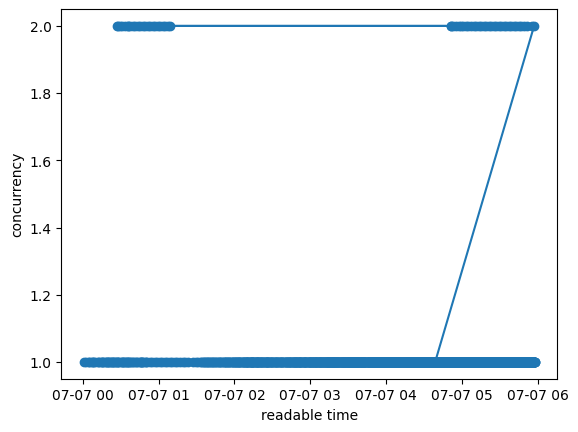

In [21]:
sub_df = df.loc[df.content == 'content-05335']

ts = sub_df.readableDate.value_counts()
plt.plot(ts, marker='o')
plt.xlabel("readable time")
plt.ylabel("concurrency")


##### 4.3
What is the average performance measured when the concurrency is lower than 10?


todo

In [24]:
perf_arr = []
concurrency = df['readableDate'].value_counts()
concurrency


2019-07-07 03:56:38.634    5
2019-07-07 05:26:48.110    5
2019-07-07 00:58:38.087    5
2019-07-07 02:50:38.167    4
2019-07-07 02:55:03.910    4
                          ..
2019-07-07 04:14:45.567    1
2019-07-07 04:12:45.397    1
2019-07-07 04:10:45.391    1
2019-07-07 04:08:45.386    1
2019-07-07 05:56:30.208    1
Name: readableDate, Length: 379335, dtype: int64

##### 4.4
Starting from which concurrency can we say there is a 75% chance that the performance on a content is higher than 80%?

todo